In [ ]:
!pip install kaggle

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

fm.fontManager.addfont(path)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,508 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and dire

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_USERNAME'] = 'starsin'
os.environ['KAGGLE_KEY'] = 'ff559a02afd29d67f19bc4001d5a69f7'

api = KaggleApi()
api.authenticate()


# 2. 대회 데이터 다운로드
competition_name = "ai05-level1-project"
api.competition_download_files(competition_name, path="./data")

In [ ]:
import zipfile

zip_path = "./data/ai05-level1-project.zip"
extract_dir = "./data/ai05-level1-project"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# === 0) 기본 설정 ===
import os, json, random, numpy as np
import torch, torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from PIL import Image

# 경로
base_path     = "./data/ai05-level1-project"
img_dir       = os.path.join(base_path, "train_images")
clean_json    = "./merged_coco/train_all_robust.json"  # 병합/클린된 COCO json
work_dir      = "./checkpoints"; os.makedirs(work_dir, exist_ok=True)

# 디바이스
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [ ]:
import os, json, math, hashlib
from collections import defaultdict, Counter
from PIL import Image

base_path = "./data/ai05-level1-project"
train_img_dir = os.path.join(base_path, "train_images")
train_ann_dir = os.path.join(base_path, "train_annotations")
out_dir = "./merged_coco"
os.makedirs(out_dir, exist_ok=True)

def norm_name(p: str) -> str:
    return os.path.basename(p).strip()

def file_exists_in_train_images(fname: str) -> bool:
    return os.path.isfile(os.path.join(train_img_dir, fname))

def get_img_size_from_disk(fname: str):
    path = os.path.join(train_img_dir, fname)
    with Image.open(path) as im:
        w, h = im.size
    return w, h

def bbox_valid_clip(x, y, w, h, W, H):
    # 음수/0 폭/높이 제거 + 경계 클리핑
    x = max(0.0, float(x)); y = max(0.0, float(y))
    w = float(w); h = float(h)
    if w < 2 or h < 2:
        return None
    x2 = min(W - 1.0, x + w)
    y2 = min(H - 1.0, y + h)
    if x2 <= x or y2 <= y:
        return None
    w2 = x2 - x
    h2 = y2 - y
    return [float(x), float(y), float(w2), float(h2)]

def dedup_key(image_id, category_id, bbox):
    # 중복 ann 제거를 위한 key (좌표는 소수점 1자리까지 라운딩)
    x,y,w,h = [round(float(v), 1) for v in bbox]
    return (int(image_id), int(category_id), x,y,w,h)

def hash_cat(c):
    # 같은 id인데 name이 다른 경우를 잡기 위한 해시(리포팅용)
    return hashlib.md5(json.dumps({"id": c["id"], "name": c.get("name",""), "super": c.get("supercategory","")}, sort_keys=True).encode()).hexdigest()

In [ ]:
merged = {"images": [], "annotations": [], "categories": []}

# 1) 카테고리 수집 + 동명이인(같은 id 다른 name) 탐지
cat_by_id = {}
cat_hash_by_id = {}
cat_conflict = []

# 2) 이미지 매핑: file_name 기준으로 새 id 부여(중복 file_name은 한 장으로 통합)
file_to_new_img_id = {}
new_img_id = 1

# 3) 이미지 메타(폭/높이) 실제 디스크에서 가져오기 (annotations의 width/height 무시)
image_meta = {}   # new_img_id -> {"file_name":..., "width":..., "height":...}

# 4) 어노테이션 수집
ann_id = 1
seen_ann_keys = set()

# 리포트용 카운트
cnt = {
    "folders_scanned": 0,
    "json_scanned": 0,
    "images_declared": 0,
    "images_kept": 0,
    "images_missing_file": 0,
    "anns_declared": 0,
    "anns_kept": 0,
    "anns_bad_bbox": 0,
    "anns_orphan_image": 0,
    "anns_dup_removed": 0,
}

for folder in sorted(os.listdir(train_ann_dir)):
    if not folder.endswith("_json"):
        continue
    cnt["folders_scanned"] += 1
    ann_dir = os.path.join(train_ann_dir, folder)

    for dp, _, files in os.walk(ann_dir):
        for f in files:
            if not f.lower().endswith(".json"):
                continue
            cnt["json_scanned"] += 1
            jp = os.path.join(dp, f)
            try:
                with open(jp, "r") as fh:
                    j = json.load(fh)
            except Exception as e:
                print(f"⚠️ JSON 로드 실패: {jp} ({e})")
                continue

            images = j.get("images", [])
            anns   = j.get("annotations", [])
            cats   = j.get("categories", [])

            # ---- categories 수집 & 충돌 리포트 ----
            for c in cats:
                cid = int(c["id"])
                h = hash_cat(c)
                if cid not in cat_by_id:
                    cat_by_id[cid] = {"id": cid, "name": c.get("name",""), "supercategory": c.get("supercategory","pill")}
                    cat_hash_by_id[cid] = h
                else:
                    if cat_hash_by_id[cid] != h:
                        cat_conflict.append((cid, cat_by_id[cid], {"id": cid, "name": c.get("name",""), "supercategory": c.get("supercategory","pill")}))
            # ---- images 처리 ----
            for im in images:
                cnt["images_declared"] += 1
                file_name = norm_name(im.get("file_name") or im.get("imgfile") or "")
                if not file_name:
                    continue
                # 실제 파일 존재 검사
                if not file_exists_in_train_images(file_name):
                    cnt["images_missing_file"] += 1
                    continue
                # 새로운 id 부여(이미 있으면 재사용)
                if file_name not in file_to_new_img_id:
                    # 폭/높이 실제 디스크에서
                    W,H = get_img_size_from_disk(file_name)
                    file_to_new_img_id[file_name] = new_img_id
                    image_meta[new_img_id] = {"id": new_img_id, "file_name": file_name, "width": W, "height": H}
                    new_img_id += 1
                    cnt["images_kept"] += 1

            # ---- annotations 처리 ----
            for a in anns:
                cnt["anns_declared"] += 1
                # 원본 image_id -> file_name 찾기
                src_im = None
                for im in images:
                    if im["id"] == a.get("image_id"):
                        src_im = im
                        break
                if src_im is None:
                    cnt["anns_orphan_image"] += 1
                    continue

                file_name = norm_name(src_im.get("file_name") or src_im.get("imgfile") or "")
                if not file_name or file_name not in file_to_new_img_id:
                    # 이미지가 파일 미존재로 드랍된 케이스
                    cnt["anns_orphan_image"] += 1
                    continue
                new_id = file_to_new_img_id[file_name]
                W = image_meta[new_id]["width"]
                H = image_meta[new_id]["height"]

                # bbox 정합성/클립
                bbox = a.get("bbox")
                if not bbox or len(bbox) != 4:
                    cnt["anns_bad_bbox"] += 1
                    continue
                fixed = bbox_valid_clip(bbox[0], bbox[1], bbox[2], bbox[3], W, H)
                if fixed is None:
                    cnt["anns_bad_bbox"] += 1
                    continue

                cat_id = int(a["category_id"])
                if cat_id not in cat_by_id:
                    # 미등록 카테고리면 스킵
                    continue

                # 중복 ann 제거
                k = dedup_key(new_id, cat_id, fixed)
                if k in seen_ann_keys:
                    cnt["anns_dup_removed"] += 1
                    continue
                seen_ann_keys.add(k)

                merged_ann = {
                    "id": ann_id,
                    "image_id": new_id,
                    "category_id": cat_id,
                    "bbox": fixed,
                    "area": float(fixed[2]*fixed[3]),
                    "iscrowd": int(a.get("iscrowd", 0)),
                    "segmentation": a.get("segmentation", []),  # 비어 있어도 OK (Mask R-CNN은 우리가 나중에 사각마스크 생성)
                }
                merged["annotations"].append(merged_ann)
                ann_id += 1

# 최종 이미지/카테고리 기록
merged["images"] = [image_meta[i] for i in sorted(image_meta)]
merged["categories"] = [cat_by_id[cid] for cid in sorted(cat_by_id)]

# 저장
out_json = os.path.join(out_dir, "train_all_robust.json")
with open(out_json, "w") as f:
    json.dump(merged, f, indent=2, ensure_ascii=False)

print("✅ COCO 병합 완료")
print("   images:", len(merged["images"]),
      "| anns:", len(merged["annotations"]),
      "| cats:", len(merged["categories"]))
print("📊 리포트:", cnt)

if cat_conflict:
    print("⚠️ 카테고리 충돌 감지(같은 id, 다른 name). 샘플 5개만 표시:")
    for row in cat_conflict[:5]:
        cid, oldc, newc = row
        print(f"  id={cid} old={oldc} new={newc}")

✅ COCO 병합 완료
   images: 1489 | anns: 4524 | cats: 73
📊 리포트: {'folders_scanned': 498, 'json_scanned': 4526, 'images_declared': 4526, 'images_kept': 1489, 'images_missing_file': 0, 'anns_declared': 4526, 'anns_kept': 0, 'anns_bad_bbox': 2, 'anns_orphan_image': 0, 'anns_dup_removed': 0}


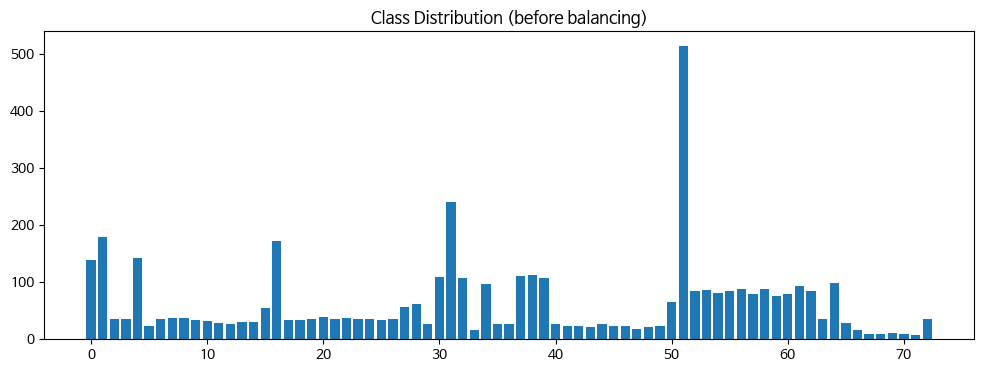

총 클래스 : 73
샘플 10개 미만 클래스: 3


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

with open(clean_json, "r") as f:
    coco = json.load(f)

cat_counter = Counter([a["category_id"] for a in coco["annotations"]])
plt.figure(figsize=(12,4))
plt.bar(range(len(cat_counter)), cat_counter.values())
plt.title("Class Distribution (before balancing)")
plt.show()

print("총 클래스 :", len(cat_counter))
print("샘플 10개 미만 클래스:", sum(v < 10 for v in cat_counter.values()))

In [ ]:
# === 1) Dataset / Loader (bbox→rect mask) ===

def get_transform(train=True):
    # 박스를 비틀지 않는 photometric 계열 위주
    aug = [T.ToTensor()]
    if train:
        aug += [
            T.ColorJitter(0.15, 0.15, 0.15, 0.03),
            T.RandomAdjustSharpness(1.3, p=0.25),
            T.RandomAutocontrast(p=0.2),
        ]
    return T.Compose(aug)

def boxes_to_rect_masks(size_hw, boxes_xyxy):
    H, W = size_hw
    if len(boxes_xyxy) == 0:
        return np.zeros((0, H, W), dtype=np.uint8)
    masks = []
    for (x1,y1,x2,y2) in boxes_xyxy:
        x1, y1, x2, y2 = map(float, (x1,y1,x2,y2))
        x1 = max(0, min(W-1, x1)); x2 = max(0, min(W-1, x2))
        y1 = max(0, min(H-1, y1)); y2 = max(0, min(H-1, y2))
        m = np.zeros((H,W), dtype=np.uint8)
        if x2 > x1 and y2 > y1:
            m[int(y1):int(y2), int(x1):int(x2)] = 1
        masks.append(m)
    return np.stack(masks, axis=0)

class CocoLikeMaskDataset(torch.utils.data.Dataset):
    """
    - COCO categories의 id를 0-based index로 매핑하여 labels 생성
    - segmentation이 없어도 bbox를 사각 마스크로 rasterize
    """
    def __init__(self, img_dir, coco_json, transforms=None, train=True):
        with open(coco_json, "r") as f:
            coco = json.load(f)
        self.img_dir = img_dir
        self.transforms = transforms
        self.train = train

        self.images  = {im["id"]: im for im in coco["images"]}
        self.img_ids = list(self.images.keys())

        self.anns_by_img = {im_id: [] for im_id in self.img_ids}
        for a in coco["annotations"]:
            self.anns_by_img[a["image_id"]].append(a)

        self.cat_ids = sorted({c["id"] for c in coco["categories"]})
        # 0..K-1 ↔ real cat_id
        self.cat_id_to_idx = {cid:i for i,cid in enumerate(self.cat_ids)}
        self.idx_to_catid  = {i:cid for cid,i in self.cat_id_to_idx.items()}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        im_meta = self.images[img_id]
        img_path = os.path.join(self.img_dir, im_meta["file_name"])
        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        boxes, labels, areas, iscrowd = [], [], [], []
        for a in self.anns_by_img.get(img_id, []):
            if "bbox" not in a or not a["bbox"]:
                continue
            x, y, w, h = a["bbox"]
            boxes.append([x, y, x+w, y+h])
            labels.append(self.cat_id_to_idx[a["category_id"]])
            areas.append(w*h); iscrowd.append(a.get("iscrowd", 0))

        boxes_t = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,4), dtype=torch.float32)
        labels_t= torch.as_tensor(labels, dtype=torch.int64)   if labels else torch.zeros((0,), dtype=torch.int64)
        masks_np= boxes_to_rect_masks((H,W), boxes_t.numpy())   # [N,H,W]
        masks_t = torch.as_tensor(masks_np, dtype=torch.uint8)

        target = {
            "boxes": boxes_t,
            "labels": labels_t,
            "masks":  masks_t,
            "image_id": torch.tensor([img_id]),
            "area":   torch.as_tensor(areas, dtype=torch.float32) if areas else torch.zeros((0,), dtype=torch.float32),
            "iscrowd":torch.as_tensor(iscrowd, dtype=torch.int64) if iscrowd else torch.zeros((0,), dtype=torch.int64),
        }

        img = self.transforms(img) if self.transforms else T.ToTensor()(img)
        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# === 2) split & loader ===
full_ds = CocoLikeMaskDataset(img_dir, clean_json, transforms=get_transform(train=True), train=True)
indices = list(range(len(full_ds)))
random.Random(0).shuffle(indices)
split = int(0.9 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]

train_ds = Subset(full_ds, train_idx)
# val은 augmentation off
val_ds   = Subset(CocoLikeMaskDataset(img_dir, clean_json, transforms=get_transform(train=False), train=False),
                  val_idx)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)

if isinstance(full_ds, torch.utils.data.Subset):
    num_classes = len(full_ds.dataset.cat_ids)
else:
    num_classes = len(full_ds.cat_ids)


print("✅ train:", len(train_ds), "val:", len(val_ds), "classes:", num_classes)

✅ train: 1340 val: 149 classes: 73


In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch
from torch.optim import AdamW

# =============================
# 1️⃣ 모델 로드 (COCO 프리트레인)
# =============================
weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
model = maskrcnn_resnet50_fpn_v2(weights=weights)

# 해상도 조정 (IoU@0.9 대응)
model.transform.min_size = (1024,)
model.transform.max_size = 1536

# =============================
# 2️⃣ 커스텀 헤드 교체
# =============================
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

# =============================
# 3️⃣ GPU로 이동
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 💥 반드시 이 타이밍에 GPU로 올려야 함

# =============================
# 4️⃣ Optimizer & Scheduler
# =============================
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4,
    weight_decay=1e-4
)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth


100%|██████████| 177M/177M [00:00<00:00, 246MB/s]


In [ ]:
# === 4) COCO eval utils ===
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def _get_base_ds(ds_or_subset):
    return getattr(ds_or_subset, "dataset", ds_or_subset)

def set_inference_params(model, score_thr=0.0001, nms_thr=0.5, detections_per_img=1000):
    model.roi_heads.score_thresh = score_thr
    model.roi_heads.nms_thresh = nms_thr
    model.roi_heads.detections_per_img = detections_per_img
    return model

def _xyxy_to_xywh(boxes):
    boxes = np.asarray(boxes, dtype=np.float32)
    out = boxes.copy()
    out[:,2] = out[:,2]-out[:,0]; out[:,3] = out[:,3]-out[:,1]
    return out

@torch.no_grad()
def run_coco_eval_bbox(model, val_loader, val_json_path, idx_to_catid, device="cuda",
                       iou_lo=0.75, iou_hi=0.95, verbose=True):
    model.eval()
    set_inference_params(model, 0.0001, 0.5, 1000)  # 평가용 완화
    cocoGt = COCO(val_json_path)

    dets = []
    for imgs, tgts in val_loader:
        imgs = [im.to(device) for im in imgs]
        outs = model(imgs)
        for out, tgt in zip(outs, tgts):
            img_id = int(tgt["image_id"].item())
            boxes  = out["boxes"].cpu().numpy()
            scores = out["scores"].cpu().numpy()
            labels = out["labels"].cpu().numpy()  # 0-based(idx)

            cat_ids = np.array([int(idx_to_catid[int(l)]) for l in labels], dtype=np.int64)
            xywh = _xyxy_to_xywh(boxes)
            for b, s, c in zip(xywh, scores, cat_ids):
                dets.append({
                    "image_id": img_id,
                    "category_id": int(c),
                    "bbox": [float(b[0]), float(b[1]), float(b[2]), float(b[3])],
                    "score": float(s)
                })

    cocoDt = cocoGt.loadRes(dets) if len(dets)>0 else COCO()
    cocoEval = COCOeval(cocoGt, cocoDt, iouType='bbox')
    cocoEval.params.useCats = 1
    cocoEval.evaluate(); cocoEval.accumulate()
    if verbose: cocoEval.summarize()

    precisions = cocoEval.eval['precision']  # [T,R,K,A,M]
    iou_thrs  = cocoEval.params.iouThrs      # [T]
    A_idx = 0; M_idx = -1
    mask = (iou_thrs >= iou_lo-1e-9) & (iou_thrs <= iou_hi+1e-9)
    pr = precisions[mask, :, :, A_idx, M_idx]
    pr = pr[pr > -1]
    ap = float(np.mean(pr)) if pr.size else 0.0
    if verbose:
        print(f"mAP@[{iou_lo:.2f}:{iou_hi:.2f}] = {ap:.4f}")
    return ap

def export_val_coco_json(base_ds, subset_idx, src_json_path, out_json_path):
    with open(src_json_path, "r") as f:
        coco = json.load(f)
    val_img_ids = set(int(base_ds.img_ids[i]) for i in subset_idx)
    images = [im for im in coco["images"] if int(im["id"]) in val_img_ids]
    keep_ids = set(int(im["id"]) for im in images)
    anns   = [a for a in coco["annotations"] if int(a["image_id"]) in keep_ids]
    out = {"images": images, "annotations": anns, "categories": coco["categories"]}
    os.makedirs(os.path.dirname(out_json_path), exist_ok=True)
    with open(out_json_path, "w") as f:
        json.dump(out, f, indent=2, ensure_ascii=False)
    return out_json_path

# val GT JSON 생성
val_json_path = "./merged_coco/val_gt.json"
_ = export_val_coco_json(_get_base_ds(full_ds), val_idx, clean_json, val_json_path)

# 라벨 매핑
base_ds = _get_base_ds(full_ds)
idx_to_catid = base_ds.idx_to_catid

In [ ]:
# === Cell 1: 기본 설정 & 유틸 ===
import os, json, torch, numpy as np
from torch.utils.data import DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_base_dataset(ds):
    """Subset/원본 구분 없이 베이스 Dataset 객체를 돌려줌."""
    return ds.dataset if isinstance(ds, Subset) else ds

def _xyxy_to_xywh(boxes):
    boxes = np.asarray(boxes, dtype=np.float32)
    out = boxes.copy()
    out[:, 2] = out[:, 2] - out[:, 0]
    out[:, 3] = out[:, 3] - out[:, 1]
    return out

In [ ]:
# === Cell 2: COCO val_gt.json 생성 (info/licenses 보존) ===
def export_val_coco_json(base_ds, subset_idx, src_json_path, out_json_path):
    """
    base_ds: (베이스) 학습에 쓴 COCO Dataset (예: CocoLikeMaskDataset)
    subset_idx: val Subset의 인덱스 리스트
    src_json_path: 병합된 전체 train_all.json 같은 원본 COCO
    out_json_path: 저장할 val_gt.json 경로
    """
    with open(src_json_path, "r") as f:
        coco = json.load(f)

    # val 이미지 id 모으기
    val_img_ids = set(int(base_ds.img_ids[i]) for i in subset_idx)

    # 이미지/어노테이션 필터링
    images = [im for im in coco["images"] if int(im["id"]) in val_img_ids]
    keep_ids = set(int(im["id"]) for im in images)
    anns   = [a for a in coco["annotations"] if int(a["image_id"]) in keep_ids]

    # info/licenses 보존(없으면 기본값 주입)
    info = coco.get("info", {"description": "auto-generated val split"})
    licenses = coco.get("licenses", [])

    out = {
        "info": info,
        "licenses": licenses,
        "images": images,
        "annotations": anns,
        "categories": coco["categories"],
    }
    os.makedirs(os.path.dirname(out_json_path), exist_ok=True)
    with open(out_json_path, "w") as f:
        json.dump(out, f, indent=2, ensure_ascii=False)
    return out_json_path

In [ ]:
# === Cell 3: COCO mAP@[0.75:0.95] 평가 함수 ===
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

@torch.no_grad()
def run_coco_eval_bbox(model, val_loader, val_json_path, idx_to_catid, device="cuda",
                       iou_lo=0.75, iou_hi=0.95, verbose=True):
    """
    model: Mask R-CNN 등 torchvision detection 모델
    val_loader: (images, targets) 배치 제공하는 DataLoader (targets는 최소 image_id 포함)
    val_json_path: COCO GT json (위 Cell 2로 만든 val_gt.json 추천)
    idx_to_catid: 모델 라벨 인덱스(0..K-1) -> 실제 category_id 매핑 dict
    """
    model.eval()

    # 평가 시 후보를 많이 남기기 (PR커브용; mAP 계산에 유리)
    if hasattr(model, "roi_heads"):
        model.roi_heads.score_thresh = 0.0001
        model.roi_heads.nms_thresh = 0.50
        model.roi_heads.detections_per_img = 1000

    cocoGt = COCO(val_json_path)

    # ✅ 방어: info/licenses 없으면 주입
    if 'info' not in cocoGt.dataset:
        cocoGt.dataset['info'] = {"description": "auto-generated val split"}
    if 'licenses' not in cocoGt.dataset:
        cocoGt.dataset['licenses'] = []

    dets = []
    for imgs, tgts in val_loader:
        imgs = [im.to(device) for im in imgs]
        outs = model(imgs)
        for out, tgt in zip(outs, tgts):
            # targets는 GPU에 올릴 필요 없음 (image_id만 쓰니까)
            img_id = int(tgt["image_id"].item())
            boxes  = out["boxes"].detach().cpu().numpy()
            scores = out["scores"].detach().cpu().numpy()
            labels = out["labels"].detach().cpu().numpy()  # 0-based idx

            # idx -> real category_id
            cat_ids = np.array([int(idx_to_catid[int(l)]) for l in labels], dtype=np.int64)
            xywh = _xyxy_to_xywh(boxes)

            for b, s, c in zip(xywh, scores, cat_ids):
                dets.append({
                    "image_id": img_id,
                    "category_id": int(c),
                    "bbox": [float(b[0]), float(b[1]), float(b[2]), float(b[3])],
                    "score": float(s)
                })

    # ✅ 빈 결과도 안전하게
    cocoDt = cocoGt.loadRes(dets if len(dets) > 0 else [])

    cocoEval = COCOeval(cocoGt, cocoDt, iouType='bbox')
    cocoEval.params.useCats = 1
    cocoEval.evaluate(); cocoEval.accumulate()
    if verbose:
        cocoEval.summarize()

    precisions = cocoEval.eval['precision']  # [T,R,K,A,M]
    iou_thrs  = cocoEval.params.iouThrs
    A_idx = 0; M_idx = -1
    mask = (iou_thrs >= iou_lo-1e-9) & (iou_thrs <= iou_hi+1e-9)
    pr = precisions[mask, :, :, A_idx, M_idx]
    pr = pr[pr > -1]
    ap = float(np.mean(pr)) if pr.size else 0.0
    if verbose:
        print(f"mAP@[{iou_lo:.2f}:{iou_hi:.2f}] = {ap:.4f}")
    return ap

In [ ]:
# === Cell 4: 사용 예시 ===
# 가정:
# - train_ds, val_ds, train_loader, val_loader 이미 구성됨
# - full_ds(=train+val 원본 Dataset) 존재
# - train_all.json 같은 병합 COCO 경로가 있음 → 여기서 val_gt 생성
# - model/optimizer/lr_sched 학습 끝난 상태

# 1) base dataset & idx_to_catid
base_ds = get_base_dataset(full_ds)   # CocoLikeMaskDataset 같은 원본 Dataset
idx_to_catid = base_ds.idx_to_catid   # {0: <cat_id_0>, 1: <cat_id_1>, ...}

# 2) val 인덱스 수집
if isinstance(val_ds, Subset):
    val_indices = val_ds.indices
else:
    # val_ds가 Subset이 아니라면, 전부 평가하고 싶다면 이렇게:
    val_indices = list(range(len(base_ds)))

# 3) val_gt.json 생성
src_json_path = "./merged_coco/train_all_robust.json"   # 네가 병합해둔 COCO json 경로
val_json_path = "./merged_coco/val_gt.json"
export_val_coco_json(base_ds, val_indices, src_json_path, val_json_path)

# 4) 평가 실행
ap_strict = run_coco_eval_bbox(
    model, val_loader, val_json_path, idx_to_catid, device=device,
    iou_lo=0.75, iou_hi=0.95, verbose=True
)
print(f"✅ strict mAP result: {ap_strict:.4f}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.52s).
Accumulating evaluation results...
DONE (t=1.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.786
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.746
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.584
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

In [ ]:
# === 6) Test 추론 → CSV (후처리 없이 원시 출력) ===
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

test_dir = os.path.join(base_path, "test_images")
score_thr = 0.001  # 원시 출력 최대한 보존 (평가 서버가 PR커브 통합 시 유리)

rows = []
annotation_id = 1

file_list = sorted([fn for fn in os.listdir(test_dir) if fn.lower().endswith((".png",".jpg",".jpeg"))])

model.eval()
set_inference_params(model, score_thr=0.0001, nms_thr=0.5, detections_per_img=1000)

for fn in file_list:
    img_path = os.path.join(test_dir, fn)
    img_name = os.path.splitext(fn)[0]
    img = Image.open(img_path).convert("RGB")
    x = T.ToTensor()(img).to(device)
    with torch.no_grad():
        out = model([x])[0]

    boxes  = out["boxes"].detach().cpu().numpy()
    labels = out["labels"].detach().cpu().numpy()   # 0-based idx
    scores = out["scores"].detach().cpu().numpy()

    # idx -> real cat_id
    L_cat = np.array([int(idx_to_catid[int(l)]) for l in labels], dtype=np.int64)

    for (x1,y1,x2,y2), lab, sc in zip(boxes, L_cat, scores):
        if sc < score_thr:
            continue
        rows.append({
            "annotation_id": annotation_id,
            "image_id": img_name,
            "category_id": int(lab),
            "bbox_x": round(float(x1), 2),
            "bbox_y": round(float(y1), 2),
            "bbox_w": round(float(x2 - x1), 2),
            "bbox_h": round(float(y2 - y1), 2),
            "score": round(float(sc), 4),
        })
        annotation_id += 1

csv_out = "./maskrcnn_predictions_raw.csv"
df = pd.DataFrame(rows, columns=["annotation_id","image_id","category_id","bbox_x","bbox_y","bbox_w","bbox_h","score"])
df.to_csv(csv_out, index=False, encoding="utf-8-sig")
print(f"✅ CSV 저장: {csv_out}  (rows={len(df)})")

In [ ]:
# === 7) 빠른 시각화 ===
VIS_N = 6; shown=0
for fn in file_list:
    if shown >= VIS_N: break
    p = os.path.join(test_dir, fn)
    img = Image.open(p).convert("RGB")
    x = T.ToTensor()(img).to(device)
    with torch.no_grad():
        out = model([x])[0]
    boxes = out["boxes"].cpu().numpy()
    labels= out["labels"].cpu().numpy()
    scores= out["scores"].cpu().numpy()
    L_cat = np.array([int(idx_to_catid[int(l)]) for l in labels], dtype=np.int64)

    import matplotlib.pyplot as plt, matplotlib.patches as patches
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    ax.imshow(img); ax.axis("off")
    for (x1,y1,x2,y2), lab, sc in zip(boxes, L_cat, scores):
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, max(0,y1-5), f"{lab} {sc:.2f}", fontsize=9,
                bbox=dict(facecolor="black", alpha=0.6, pad=1), color="white")
    ax.set_title(fn)
    plt.show()
    shown += 1